In [ ]:
!pip install tensorflow==2.0

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from contextlib import suppress
import os
import pandas as pd
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [2]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_d1a415b432b14c7e8a300fe5c0e55971 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='idFCJ3hcmtaW40Ec_Lj4gpiHmsPiekO5w1zY5ooIKGxT',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_d1a415b432b14c7e8a300fe5c0e55971.get_object(Bucket='windbot-donotdelete-pr-tmoc6flls831qs',Key='T1.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df = pd.read_csv(body)
df.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb149703cf8>,
      dtype=object)

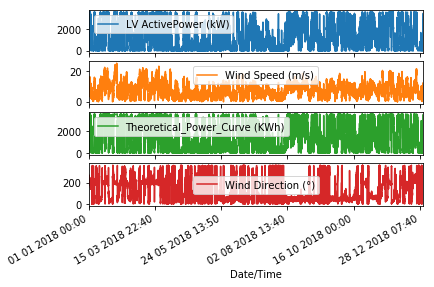

In [3]:
print(df.columns)
features_considered = ['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)']
features = df[features_considered]
features.index = df['Date/Time']
features.head()
features.plot(subplots=True)

In [4]:
#dataset scaling
TRAIN_SPLIT=(int)(len(df)*0.6)
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [5]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [6]:
past_history = 60
future_target = 6
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target  to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (60, 4)

 Target  to predict : (6,)


In [7]:
BATCH_SIZE = 512
BUFFER_SIZE = BATCH_SIZE*BATCH_SIZE

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [8]:
def create_time_steps(length):
  return list(range(-length, 0))

In [9]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

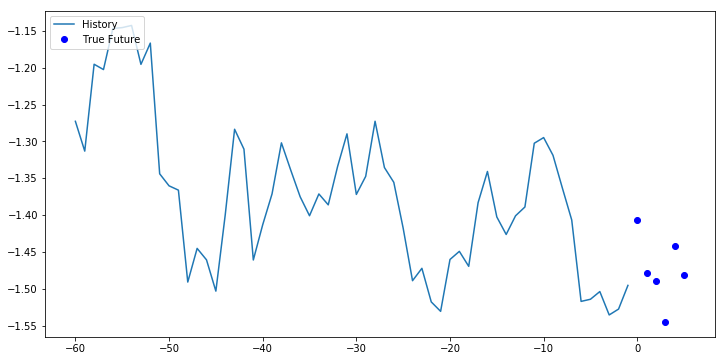

In [10]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [11]:
#creating new trained model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(216,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(tf.keras.layers.LSTM(60, activation='relu'))
multi_step_model.add(tf.keras.layers.Dropout(0.2))
multi_step_model.add(tf.keras.layers.Dense(future_target))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [27]:
#get previous trained model
multi_step_modell = tf.keras.models.load_model('WindBot')

In [13]:
EVALUATION_INTERVAL = 36
EPOCHS = 1
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=36)

Train for 36 steps, validate for 36 steps
36/36 [==============================] - 146s 4s/step - loss: 0.5177 - val_loss: 0.2837


In [14]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

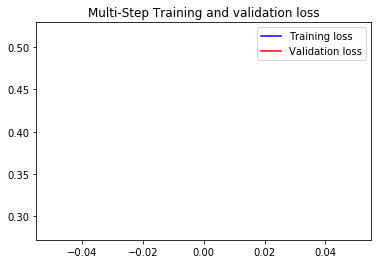

In [15]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

[2766.02454874   12.6841319  3042.28083535  260.49498507]
[2709.08905007   12.49020869 2982.38557919  256.23242494]
[2747.07633475   12.61959399 3022.34760991  259.07639907]
[2767.83051717   12.69028306 3044.18068595  260.63019156]
[2513.72233179   11.82478656 2776.86284017  241.60600727]
[2368.03641757   11.32857803 2623.60353177  230.6990163 ]


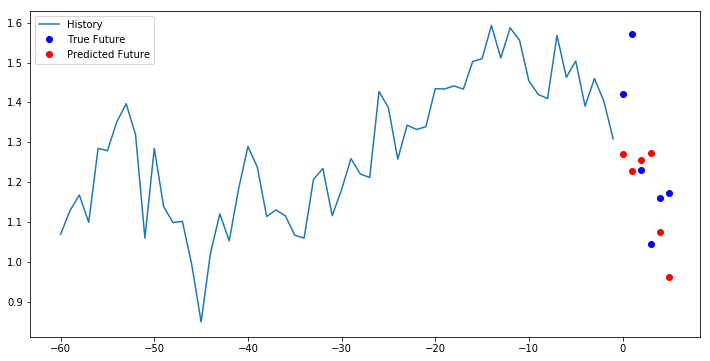

In [28]:
for x, y in val_data_multi.take(1):
  for i in range(0,6):
    #upscaled result
    print((multi_step_model.predict(x)[0][i]*data_std)+data_mean)
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

In [18]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient
wml_credentials = {
  "apikey": "oPswTDwdjUqhMAXw2eU0u5TfOlEBN4KCYsClmDSKWgcj",
  "iam_apikey_description": "Auto-generated for key 34595acb-f990-40f9-8f32-ecc4fd561844",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0d1ca5602e884c5d946896c2af3b8bb0::serviceid:ServiceId-58340dd1-81fb-41c7-a101-0289e762f80f",
  "instance_id": "dca3fe97-5753-4cfa-a8f5-096aac79666d",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}
client = WatsonMachineLearningAPIClient( wml_credentials )

In [25]:
filename = 'WindBot'
# Delete a duplicate file if exists.
with suppress(OSError):
    os.remove(filename)
multi_step_model.save(filename,overwrite=True)

#compress keras model
tar_filename = filename + '.tgz'
cmdstring = 'tar -zcvf ' + tar_filename + ' ' + filename
print(cmdstring)
os.system(cmdstring)

tar -zcvf WindBot.tgz WindBot


0

In [31]:
metadata = {
    client.repository.ModelMetaNames.NAME: "WindBot",
    client.repository.ModelMetaNames.FRAMEWORK_NAME: "tensorflow",
    client.repository.ModelMetaNames.FRAMEWORK_VERSION: "1.15",
    client.repository.ModelMetaNames.FRAMEWORK_LIBRARIES: [{'name':'keras', 'version': '2.2.2'}]}
model_details = client.repository.store_model( model="WindBot", meta_props=metadata )

WMLClientError: Publishing model failed.
Reason: module 'tensorflow' has no attribute 'Session'

In [24]:
model_id = model_details["metadata"]["guid"]
deployment_details = client.deployments.create( artifact_uid=model_id, name="WindBot" )



#######################################################################################

Synchronous deployment creation for uid: '0fa5cfbf-264f-4a7e-baeb-562fc940aa98' started

#######################################################################################


INITIALIZING
DEPLOY_FAILURE

--------------------------
Deployment creation failed
--------------------------


Cannot find any suitable instance to fit deployment 46fd7c69-9d3f-4974-af81-7a723ca931d9 of size 0


WMLClientError: Deployment creation failed. Errors: [{'code': 'instance_with_insufficient_memory', 'message': 'Cannot find any suitable instance to fit deployment 46fd7c69-9d3f-4974-af81-7a723ca931d9 of size 0'}]

In [ ]:
# Test the deployment
model_endpoint_url = client.deployments.get_scoring_url( deployment_details )
payload = { "values" : X_test.tolist() }
client.deployments.score( model_endpoint_url, payload )